# regression_part_1_linear_regression

## Data import and test

In [155]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.model_selection import train_test_split, KFold, LeaveOneOut
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import KFold


#Martim added imports from week 8
from sklearn import model_selection
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge


In [156]:
name_data_file="heart_failure_clinical_records_dataset"

data = pd.read_csv(f"../../raw_data/{name_data_file}.csv", na_values=["?"])

In [157]:
data

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,62.0,0,61,1,38,1,155000.00,1.1,143,1,1,270,0
295,55.0,0,1820,0,38,0,270000.00,1.2,139,0,0,271,0
296,45.0,0,2060,1,60,0,742000.00,0.8,138,0,0,278,0
297,45.0,0,2413,0,38,0,140000.00,1.4,140,1,1,280,0


## Data Processing

In [158]:
# continuous and binary columns
continuous_cols = [
    "age",
    "creatinine_phosphokinase", 
    "ejection_fraction",
    "platelets",
    "serum_creatinine",
    "serum_sodium",
]
binary_cols = ["anaemia", "diabetes", "high_blood_pressure", "sex", "smoking", "DEATH_EVENT"]

from what Godinho and Ribau discussed we don´t need a one out of k encoding

In [159]:
# Predictors and target
y = data["time"]
X = data.drop(columns=["time"])  # remove target

## Log transform of CDK column

In [160]:
# Log-transform: creatinine_phosphokinase column
X["creatinine_phosphokinase"] = np.log1p(X["creatinine_phosphokinase"])

#### check data

In [161]:
X

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,DEATH_EVENT
0,75.0,0,6.368187,0,20,1,265000.00,1.9,130,1,0,1
1,55.0,0,8.969796,0,38,0,263358.03,1.1,136,1,0,1
2,65.0,0,4.990433,0,20,0,162000.00,1.3,129,1,1,1
3,50.0,1,4.718499,0,20,0,210000.00,1.9,137,1,0,1
4,65.0,1,5.081404,1,20,0,327000.00,2.7,116,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
294,62.0,0,4.127134,1,38,1,155000.00,1.1,143,1,1,0
295,55.0,0,7.507141,0,38,0,270000.00,1.2,139,0,0,0
296,45.0,0,7.630947,1,60,0,742000.00,0.8,138,0,0,0
297,45.0,0,7.789040,0,38,0,140000.00,1.4,140,1,1,0


## Regularization parameter λ and Generalization Error

### with DEATH_EVENT

#### λ range

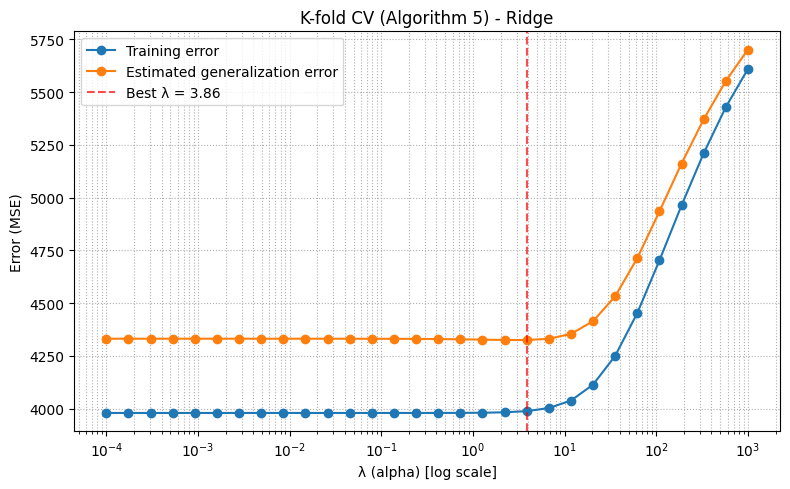

In [180]:
# --- 3. Cross-validation setup (Algorithm 5) ---
K = 10
kf = KFold(n_splits=K, shuffle=True, random_state=42)
lambdas = np.logspace(-4, 3, 30)  # same search grid as in class

# Containers
train_err_mean, train_err_std = [], []
gen_err_est, test_err_std = [], []

# --- 4. Helper function for z-score standardization ---
def standardize_continuous(X_train_df, X_test_df, cont_cols):
    """Standardize continuous variables using train fold statistics."""
    mu = X_train_df[cont_cols].mean(axis=0)
    sigma = X_train_df[cont_cols].std(axis=0, ddof=0).replace(0, 1.0)

    X_train_std = X_train_df.copy()
    X_test_std = X_test_df.copy()

    for X_ in [X_train_std, X_test_std]:
        X_[cont_cols] = X_[cont_cols].astype("float64")
        X_.loc[:, cont_cols] = (X_[cont_cols] - mu) / sigma
    return X_train_std, X_test_std

# --- 5. K-fold CV across λ values ---
N_total = len(X)
for lam in lambdas:
    fold_train_errs, fold_test_errs, fold_weights = [], [], []

    for train_idx, test_idx in kf.split(X, y):
        X_train, X_test = X.iloc[train_idx].copy(), X.iloc[test_idx].copy()
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        X_train, X_test = standardize_continuous(X_train, X_test, continuous_cols)

        model = Ridge(alpha=lam, random_state=42)
        model.fit(X_train, y_train)

        fold_train_errs.append(mean_squared_error(y_train, model.predict(X_train)))
        fold_test_errs.append(mean_squared_error(y_test, model.predict(X_test)))
        fold_weights.append(len(test_idx) / N_total)

    # Aggregate fold errors
    train_err_mean.append(np.mean(fold_train_errs))
    train_err_std.append(np.std(fold_train_errs, ddof=1))
    gen_err_est.append(np.sum(np.array(fold_weights) * np.array(fold_test_errs)))
    test_err_std.append(np.std(fold_test_errs, ddof=1))

# --- 6. Compile results ---
cv_table = pd.DataFrame({
    "lambda": lambdas,
    "train_mse_mean": train_err_mean,
    "train_mse_std": train_err_std,
    "gen_mse_est": gen_err_est,
    "test_mse_std": test_err_std,
})

best_idx = np.argmin(cv_table["gen_mse_est"])
best_lambda = cv_table.loc[best_idx, "lambda"]
best_gen_mse = cv_table.loc[best_idx, "gen_mse_est"]

# --- 7. Plot CV results ---
plt.figure(figsize=(8, 5))
plt.semilogx(lambdas, cv_table["train_mse_mean"], "o-", label="Training error")
plt.semilogx(lambdas, cv_table["gen_mse_est"], "o-", label="Estimated generalization error")
plt.axvline(best_lambda, linestyle="--", color="r", alpha=0.7, label=f"Best λ = {best_lambda:.3g}")
plt.xlabel("λ (alpha) [log scale]")
plt.ylabel("Error (MSE)")
plt.title("K-fold CV (Algorithm 5) - Ridge")
plt.legend()
plt.grid(True, which="both", ls=":")
plt.tight_layout()
plt.show()

===== 10-fold CV (Ridge) — continuous-only scaling =====
     lambda  train_mse_mean  train_mse_std  gen_mse_est  test_mse_std
   0.000100     3980.173730     102.896916  4331.814384    982.280792
   0.000174     3980.173730     102.896916  4331.814054    982.280918
   0.000304     3980.173730     102.896916  4331.813478    982.281138
   0.000530     3980.173730     102.896916  4331.812475    982.281523
   0.000924     3980.173731     102.896916  4331.810727    982.282192
   0.001610     3980.173732     102.896917  4331.807679    982.283360
   0.002807     3980.173735     102.896917  4331.802367    982.285395
   0.004894     3980.173746     102.896917  4331.793113    982.288945
   0.008532     3980.173779     102.896917  4331.776997    982.295134
   0.014874     3980.173880     102.896917  4331.748957    982.305931
   0.025929     3980.174186     102.896919  4331.700238    982.324772
   0.045204     3980.175115     102.896924  4331.615802    982.357674
   0.078805     3980.177934     1

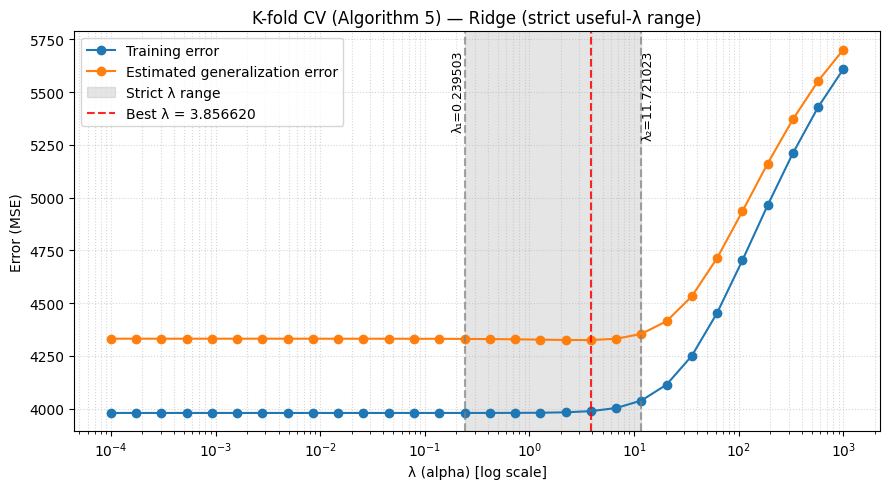


===== Coefficients (best λ model, standardized scale) =====
                 feature  coef_std_scale
             DEATH_EVENT      -81.708236
     high_blood_pressure      -22.297652
                 anaemia      -12.924815
       ejection_fraction       -6.422631
                     sex       -5.711328
creatinine_phosphokinase        5.675972
                     age       -4.985105
                 smoking       -4.656929
                diabetes        2.105878
               platelets       -1.111240
        serum_creatinine        1.094273
            serum_sodium        1.089973


In [177]:
# --- Useful λ range: strict relative + tightened 1-SE ---
gen = cv_table["gen_mse_est"].values
sd  = cv_table["test_mse_std"].values
lams = cv_table["lambda"].values.astype(float)
K_eff = K

# Índice e valor do mínimo
idx_min = int(np.argmin(gen))
best_lambda = float(lams[idx_min])
best_gen_mse = float(gen[idx_min])

# ================================
# 🔹 Parâmetros otimizados (sem cap)
# ================================
rel_tol   = 0.01    # 1% acima do mínimo
se_factor = 0.25    # 0.25-SE (mais restrito)
max_span  = 5       # no máximo 5 pontos para cada lado

# ================================
# 🔹 Threshold = mais apertado entre critério relativo e SE
# ================================
se_min = sd[idx_min] / np.sqrt(K_eff)
thr_rel = best_gen_mse * (1.0 + rel_tol)
thr_se  = best_gen_mse + se_factor * se_min
threshold = min(thr_rel, thr_se)

# Índices com erro dentro do threshold
ok = np.where(gen <= threshold)[0]

# Encontrar bloco contíguo que contém o mínimo
left_idx = idx_min
while (left_idx - 1) in ok:
    left_idx -= 1
right_idx = idx_min
while (right_idx + 1) in ok:
    right_idx += 1

# ================================
# 🔹 Limitar intervalo para evitar exageros (apenas pelo nº de pontos)
# ================================
left_idx  = max(left_idx,  idx_min - max_span)
right_idx = min(right_idx, idx_min + max_span)

# Extrair os valores de λ correspondentes
lambda_left  = float(lams[left_idx])
lambda_right = float(lams[right_idx])
useful_range = (lambda_left, lambda_right)

print("===== 10-fold CV (Ridge) — continuous-only scaling =====")
print(cv_table.to_string(index=False, float_format=lambda v: f"{v:.6f}"))
print(f"\nBest λ (alpha): {best_lambda:.6g}")
print(f"Estimated generalization error (MSE): {best_gen_mse:.6f}")
print(f"Useful λ range (strict): {useful_range[0]:.6f} → {useful_range[1]:.6f} "
      f"(rel_tol={rel_tol*100:.1f}%, se_factor={se_factor})")

# --- Plot ---
plt.figure(figsize=(9,5))
plt.semilogx(lams, cv_table["train_mse_mean"], marker="o", label="Training error")
plt.semilogx(lams, cv_table["gen_mse_est"],  marker="o", label="Estimated generalization error")

# Banda + limites
plt.axvspan(useful_range[0], useful_range[1], color="gray", alpha=0.2, label="Strict λ range")
plt.axvline(best_lambda, linestyle="--", color="red", alpha=0.85, label=f"Best λ = {best_lambda:.6f}")
plt.axvline(useful_range[0], linestyle="--", color="gray", alpha=0.7)
plt.axvline(useful_range[1], linestyle="--", color="gray", alpha=0.7)

# Add text labels with REAL λ values (no rounding)
y_top = plt.ylim()[1]
plt.text(useful_range[0], y_top*0.985, f"λ₁={useful_range[0]:.6f}", rotation=90,
         va='top', ha='right', fontsize=9, color='black')
plt.text(useful_range[1], y_top*0.985, f"λ₂={useful_range[1]:.6f}", rotation=90,
         va='top', ha='left', fontsize=9, color='black')

plt.xlabel("λ (alpha) [log scale]")
plt.ylabel("Error (MSE)")
plt.title("K-fold CV (Algorithm 5) — Ridge (strict useful-λ range)")
plt.legend()
plt.grid(True, which="both", ls=":", alpha=0.5)
plt.tight_layout()
plt.show()

# Final model fit on the FULL dataset (for point 3 of part 1-A) 
# Standardize continuous columns using FULL-data stats, then refit with best λ
mu_full = X[continuous_cols].mean(axis=0)
sigma_full = X[continuous_cols].std(axis=0, ddof=0).replace(0, 1.0)

# Work only on X_std_full and cast continuous cols to float BEFORE computing stats
X_std_full = X.copy()
X_std_full[continuous_cols] = X_std_full[continuous_cols].astype("float64")

# Compute scaling stats from FULL data (on float cols)
mu_full = X_std_full[continuous_cols].mean(axis=0)
sigma_full = X_std_full[continuous_cols].std(axis=0, ddof=0).replace(0, 1.0)

# Apply z-score using FULL-data stats (note: use X_std_full on both sides)
X_std_full.loc[:, continuous_cols] = (X_std_full[continuous_cols] - mu_full) / sigma_full

# Fit final ridge with best λ
best_model = Ridge(alpha=best_lambda, random_state=42)
best_model.fit(X_std_full, y)

coef_table = pd.DataFrame({
    "feature": X_std_full.columns,
    "coef_std_scale": best_model.coef_
}).sort_values("coef_std_scale", key=np.abs, ascending=False)

print("\n===== Coefficients (best λ model, standardized scale) =====")
print(coef_table.to_string(index=False, float_format=lambda v: f"{v:.6f}"))

#### How the model computes y for a given x:

In [174]:
# --- Coefficient table with interpretation units ---
coef_df = pd.DataFrame({
    "feature": X_std_full.columns,
    "coef": best_model.coef_
})
coef_df["type"] = np.where(coef_df["feature"].isin(continuous_cols), "continuous", "binary")

# For continuous: a +1 SD change -> +coef days; for binary: 0→1 -> +coef days
coef_df["effect_unit"] = np.where(
    coef_df["type"] == "continuous",
    "per +1 SD (z-scored)",
    "0→1 change"
)

# Sort by absolute effect size
coef_df = coef_df.sort_values("coef", key=np.abs, ascending=False).reset_index(drop=True)

print("\n=== Coefficients and interpretation units ===")
print(coef_df.to_string(index=False, float_format=lambda v: f"{v:.6f}"))

# Separate clearly positive and negative drivers
top_positive = coef_df[coef_df["coef"] > 0].sort_values("coef", ascending=False).head()
top_negative = coef_df[coef_df["coef"] < 0].sort_values("coef", ascending=True).head()

print("\nTop positive drivers (increase y):")
print(top_positive.to_string(index=False))

print("\nTop negative drivers (decrease y):")
print(top_negative.to_string(index=False))


=== Coefficients and interpretation units ===
                 feature       coef       type          effect_unit
             DEATH_EVENT -81.708236     binary           0→1 change
     high_blood_pressure -22.297652     binary           0→1 change
                 anaemia -12.924815     binary           0→1 change
       ejection_fraction  -6.422631 continuous per +1 SD (z-scored)
                     sex  -5.711328     binary           0→1 change
creatinine_phosphokinase   5.675972 continuous per +1 SD (z-scored)
                     age  -4.985105 continuous per +1 SD (z-scored)
                 smoking  -4.656929     binary           0→1 change
                diabetes   2.105878     binary           0→1 change
               platelets  -1.111240 continuous per +1 SD (z-scored)
        serum_creatinine   1.094273 continuous per +1 SD (z-scored)
            serum_sodium   1.089973 continuous per +1 SD (z-scored)

Top positive drivers (increase y):
                 feature     coef

#### Example prediction

In [176]:
# --- Pick an example patient ---
example_idx = 0
example_raw = X.iloc[example_idx]
true_y = data.loc[example_idx, "time"]

def predict_from_raw_row(raw_row: pd.Series) -> float:
    """
    Predict the expected follow-up time (ŷ) for a new patient (raw_row).
    The transformations mirror those used during training.
    """
    x = raw_row.copy()

    # 1) Apply the same feature transformation as in training
    x["creatinine_phosphokinase"] = np.log1p(x["creatinine_phosphokinase"])

    # 2) Build DataFrame with the same column order as the training set
    x_df = pd.DataFrame([x], columns=X_std_full.columns)

    # 3) Ensure continuous columns are float
    x_df[continuous_cols] = x_df[continuous_cols].astype("float64")

    # 4) Standardize continuous columns using full-dataset stats
    x_df.loc[:, continuous_cols] = (x_df[continuous_cols] - mu_full) / sigma_full

    # 5) Predict using the trained ridge model
    y_hat = best_model.predict(x_df)[0]
    return float(y_hat)

# --- Predict using the same function ---
y_hat_example = predict_from_raw_row(example_raw)

# --- Print results side by side ---
print(f"\n=== Example prediction (patient index {example_idx}) ===")
print(f"True follow-up time (y):      {true_y:.2f} days")
print(f"Predicted follow-up (ŷ):      {y_hat_example:.2f} days")
print(f"Prediction error:             {y_hat_example - true_y:+.2f} days\n")

# --- Algebraic expression of the Ridge model ---
print("=== Algebraic form of the final Ridge Regression model ===\n")

intercept = best_model.intercept_
coefs = best_model.coef_

# Express model as: ŷ = intercept + Σ w_i * x_i
expression = "ŷ = {:.3f}".format(intercept)
for feat, coef in zip(X_std_full.columns, coefs):
    sign = "+" if coef >= 0 else "-"
    expression += f" {sign} {abs(coef):.3f}·{feat}"
print(expression + "\n")

# --- Contribution breakdown for this patient ---
# Build transformed version of the row (standardized like training)
x = example_raw.copy()
x["creatinine_phosphokinase"] = np.log1p(x["creatinine_phosphokinase"])
x_df = pd.DataFrame([x], columns=X_std_full.columns)
x_df[continuous_cols] = x_df[continuous_cols].astype("float64")
x_df.loc[:, continuous_cols] = (x_df[continuous_cols] - mu_full) / sigma_full

# Compute individual contributions
contrib = x_df.values[0] * coefs
contrib_df = pd.DataFrame({
    "feature": X_std_full.columns,
    "x_value": x_df.values[0],
    "coef": coefs,
    "contribution (coef*x)": contrib
})
contrib_df["abs_contribution"] = contrib_df["contribution (coef*x)"].abs()
contrib_df = contrib_df.sort_values("abs_contribution", ascending=False)

print("=== Feature contributions to prediction ===")
print(contrib_df[["feature", "x_value", "coef", "contribution (coef*x)"]]
      .to_string(index=False, float_format=lambda v: f"{v:.3f}"))


=== Example prediction (patient index 0) ===
True follow-up time (y):      4.00 days
Predicted follow-up (ŷ):      48.80 days
Prediction error:             +44.80 days

=== Algebraic form of the final Ridge Regression model ===

ŷ = 174.222 - 4.985·age - 12.925·anaemia + 5.676·creatinine_phosphokinase + 2.106·diabetes - 6.423·ejection_fraction - 22.298·high_blood_pressure - 1.111·platelets + 1.094·serum_creatinine + 1.090·serum_sodium - 5.711·sex - 4.657·smoking - 81.708·DEATH_EVENT

=== Feature contributions to prediction ===
                 feature  x_value    coef  contribution (coef*x)
             DEATH_EVENT    1.000 -81.708                -81.708
     high_blood_pressure    1.000 -22.298                -22.298
creatinine_phosphokinase   -3.253   5.676                -18.467
       ejection_fraction   -1.531  -6.423                  9.830
                     age    1.193  -4.985                 -5.947
                     sex    1.000  -5.711                 -5.711
           

In [167]:
data["time"].mean()

np.float64(130.2608695652174)

### without DEATH_EVENT

#### X feature transformation

In [181]:
# Remove variable in study 
X = X.drop(columns=["DEATH_EVENT"])

#### λ range

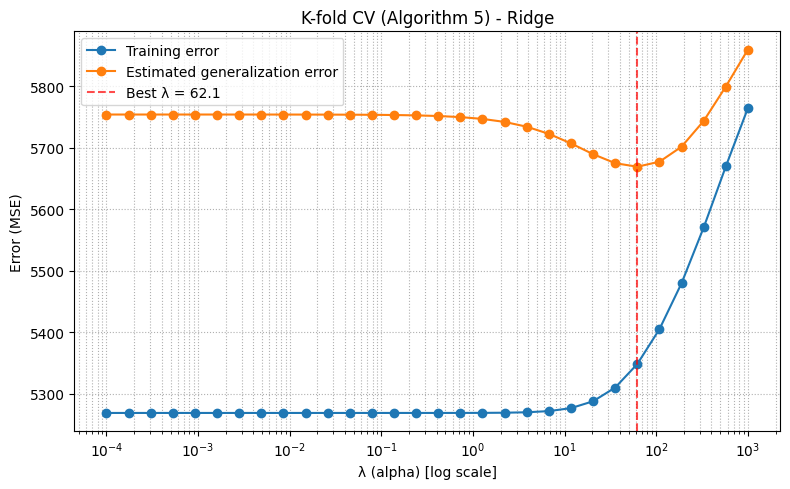

In [182]:
# --- 3. Cross-validation setup (Algorithm 5) ---
K = 10
kf = KFold(n_splits=K, shuffle=True, random_state=42)
lambdas = np.logspace(-4, 3, 30)  # same search grid as in class

# Containers
train_err_mean, train_err_std = [], []
gen_err_est, test_err_std = [], []

# --- 4. Helper function for z-score standardization ---
def standardize_continuous(X_train_df, X_test_df, cont_cols):
    """Standardize continuous variables using train fold statistics."""
    mu = X_train_df[cont_cols].mean(axis=0)
    sigma = X_train_df[cont_cols].std(axis=0, ddof=0).replace(0, 1.0)

    X_train_std = X_train_df.copy()
    X_test_std = X_test_df.copy()

    for X_ in [X_train_std, X_test_std]:
        X_[cont_cols] = X_[cont_cols].astype("float64")
        X_.loc[:, cont_cols] = (X_[cont_cols] - mu) / sigma
    return X_train_std, X_test_std

# --- 5. K-fold CV across λ values ---
N_total = len(X)
for lam in lambdas:
    fold_train_errs, fold_test_errs, fold_weights = [], [], []

    for train_idx, test_idx in kf.split(X, y):
        X_train, X_test = X.iloc[train_idx].copy(), X.iloc[test_idx].copy()
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        X_train, X_test = standardize_continuous(X_train, X_test, continuous_cols)

        model = Ridge(alpha=lam, random_state=42)
        model.fit(X_train, y_train)

        fold_train_errs.append(mean_squared_error(y_train, model.predict(X_train)))
        fold_test_errs.append(mean_squared_error(y_test, model.predict(X_test)))
        fold_weights.append(len(test_idx) / N_total)

    # Aggregate fold errors
    train_err_mean.append(np.mean(fold_train_errs))
    train_err_std.append(np.std(fold_train_errs, ddof=1))
    gen_err_est.append(np.sum(np.array(fold_weights) * np.array(fold_test_errs)))
    test_err_std.append(np.std(fold_test_errs, ddof=1))

# --- 6. Compile results ---
cv_table = pd.DataFrame({
    "lambda": lambdas,
    "train_mse_mean": train_err_mean,
    "train_mse_std": train_err_std,
    "gen_mse_est": gen_err_est,
    "test_mse_std": test_err_std,
})

best_idx = np.argmin(cv_table["gen_mse_est"])
best_lambda = cv_table.loc[best_idx, "lambda"]
best_gen_mse = cv_table.loc[best_idx, "gen_mse_est"]

# --- 7. Plot CV results ---
plt.figure(figsize=(8, 5))
plt.semilogx(lambdas, cv_table["train_mse_mean"], "o-", label="Training error")
plt.semilogx(lambdas, cv_table["gen_mse_est"], "o-", label="Estimated generalization error")
plt.axvline(best_lambda, linestyle="--", color="r", alpha=0.7, label=f"Best λ = {best_lambda:.3g}")
plt.xlabel("λ (alpha) [log scale]")
plt.ylabel("Error (MSE)")
plt.title("K-fold CV (Algorithm 5) - Ridge")
plt.legend()
plt.grid(True, which="both", ls=":")
plt.tight_layout()
plt.show()

===== 10-fold CV (Ridge) — continuous-only scaling =====
     lambda  train_mse_mean  train_mse_std  gen_mse_est  test_mse_std
   0.000100     5268.966820     154.341549  5754.331618   1460.483575
   0.000174     5268.966820     154.341549  5754.331179   1460.483169
   0.000304     5268.966820     154.341549  5754.330414   1460.482460
   0.000530     5268.966820     154.341549  5754.329080   1460.481225
   0.000924     5268.966820     154.341549  5754.326756   1460.479071
   0.001610     5268.966820     154.341549  5754.322703   1460.475317
   0.002807     5268.966820     154.341549  5754.315639   1460.468772
   0.004894     5268.966822     154.341549  5754.303325   1460.457363
   0.008532     5268.966826     154.341549  5754.281863   1460.437475
   0.014874     5268.966838     154.341548  5754.244460   1460.402809
   0.025929     5268.966875     154.341547  5754.179298   1460.342391
   0.045204     5268.966988     154.341541  5754.065827   1460.237113
   0.078805     5268.967330     1

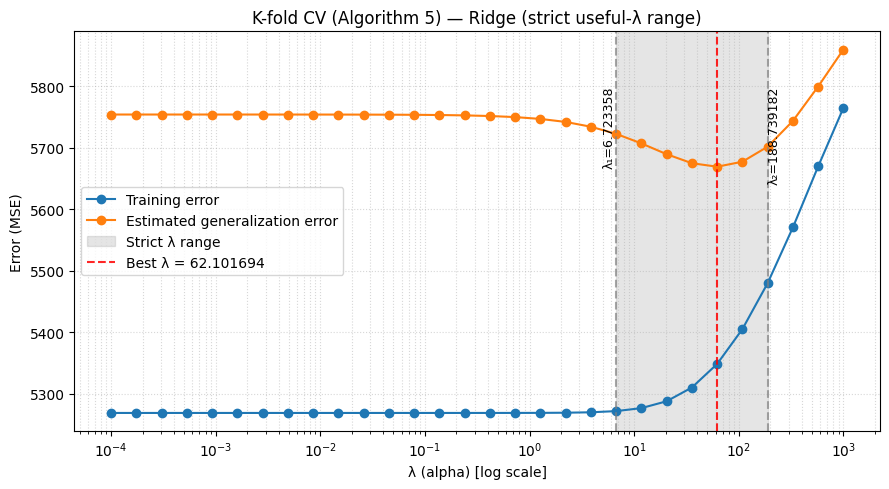


===== Coefficients (best λ model, standardized scale) =====
                 feature  coef_std_scale
     high_blood_pressure      -15.255043
                     age      -12.177509
                 anaemia       -9.632533
        serum_creatinine       -7.004276
            serum_sodium        4.006892
creatinine_phosphokinase        3.824699
       ejection_fraction        3.053731
                 smoking       -2.340475
                diabetes        1.065216
                     sex       -0.681022
               platelets       -0.468714


In [183]:
# --- Useful λ range: strict relative + tightened 1-SE ---
gen = cv_table["gen_mse_est"].values
sd  = cv_table["test_mse_std"].values
lams = cv_table["lambda"].values.astype(float)
K_eff = K

# Índice e valor do mínimo
idx_min = int(np.argmin(gen))
best_lambda = float(lams[idx_min])
best_gen_mse = float(gen[idx_min])

# ================================
# 🔹 Parâmetros otimizados (sem cap)
# ================================
rel_tol   = 0.01    # 1% acima do mínimo
se_factor = 0.25    # 0.25-SE (mais restrito)
max_span  = 5       # no máximo 5 pontos para cada lado

# ================================
# 🔹 Threshold = mais apertado entre critério relativo e SE
# ================================
se_min = sd[idx_min] / np.sqrt(K_eff)
thr_rel = best_gen_mse * (1.0 + rel_tol)
thr_se  = best_gen_mse + se_factor * se_min
threshold = min(thr_rel, thr_se)

# Índices com erro dentro do threshold
ok = np.where(gen <= threshold)[0]

# Encontrar bloco contíguo que contém o mínimo
left_idx = idx_min
while (left_idx - 1) in ok:
    left_idx -= 1
right_idx = idx_min
while (right_idx + 1) in ok:
    right_idx += 1

# ================================
# 🔹 Limitar intervalo para evitar exageros (apenas pelo nº de pontos)
# ================================
left_idx  = max(left_idx,  idx_min - max_span)
right_idx = min(right_idx, idx_min + max_span)

# Extrair os valores de λ correspondentes
lambda_left  = float(lams[left_idx])
lambda_right = float(lams[right_idx])
useful_range = (lambda_left, lambda_right)

print("===== 10-fold CV (Ridge) — continuous-only scaling =====")
print(cv_table.to_string(index=False, float_format=lambda v: f"{v:.6f}"))
print(f"\nBest λ (alpha): {best_lambda:.6g}")
print(f"Estimated generalization error (MSE): {best_gen_mse:.6f}")
print(f"Useful λ range (strict): {useful_range[0]:.6f} → {useful_range[1]:.6f} "
      f"(rel_tol={rel_tol*100:.1f}%, se_factor={se_factor})")

# --- Plot ---
plt.figure(figsize=(9,5))
plt.semilogx(lams, cv_table["train_mse_mean"], marker="o", label="Training error")
plt.semilogx(lams, cv_table["gen_mse_est"],  marker="o", label="Estimated generalization error")

# Banda + limites
plt.axvspan(useful_range[0], useful_range[1], color="gray", alpha=0.2, label="Strict λ range")
plt.axvline(best_lambda, linestyle="--", color="red", alpha=0.85, label=f"Best λ = {best_lambda:.6f}")
plt.axvline(useful_range[0], linestyle="--", color="gray", alpha=0.7)
plt.axvline(useful_range[1], linestyle="--", color="gray", alpha=0.7)

# Add text labels with REAL λ values (no rounding)
y_top = plt.ylim()[1]
plt.text(useful_range[0], y_top*0.985, f"λ₁={useful_range[0]:.6f}", rotation=90,
         va='top', ha='right', fontsize=9, color='black')
plt.text(useful_range[1], y_top*0.985, f"λ₂={useful_range[1]:.6f}", rotation=90,
         va='top', ha='left', fontsize=9, color='black')

plt.xlabel("λ (alpha) [log scale]")
plt.ylabel("Error (MSE)")
plt.title("K-fold CV (Algorithm 5) — Ridge (strict useful-λ range)")
plt.legend()
plt.grid(True, which="both", ls=":", alpha=0.5)
plt.tight_layout()
plt.show()

# Final model fit on the FULL dataset (for point 3 of part 1-A) 
# Standardize continuous columns using FULL-data stats, then refit with best λ
mu_full = X[continuous_cols].mean(axis=0)
sigma_full = X[continuous_cols].std(axis=0, ddof=0).replace(0, 1.0)

# Work only on X_std_full and cast continuous cols to float BEFORE computing stats
X_std_full = X.copy()
X_std_full[continuous_cols] = X_std_full[continuous_cols].astype("float64")

# Compute scaling stats from FULL data (on float cols)
mu_full = X_std_full[continuous_cols].mean(axis=0)
sigma_full = X_std_full[continuous_cols].std(axis=0, ddof=0).replace(0, 1.0)

# Apply z-score using FULL-data stats (note: use X_std_full on both sides)
X_std_full.loc[:, continuous_cols] = (X_std_full[continuous_cols] - mu_full) / sigma_full

# Fit final ridge with best λ
best_model = Ridge(alpha=best_lambda, random_state=42)
best_model.fit(X_std_full, y)

coef_table = pd.DataFrame({
    "feature": X_std_full.columns,
    "coef_std_scale": best_model.coef_
}).sort_values("coef_std_scale", key=np.abs, ascending=False)

print("\n===== Coefficients (best λ model, standardized scale) =====")
print(coef_table.to_string(index=False, float_format=lambda v: f"{v:.6f}"))

#### How the model computes y for a given x:

In [184]:
# --- Coefficient table with interpretation units ---
coef_df = pd.DataFrame({
    "feature": X_std_full.columns,
    "coef": best_model.coef_
})
coef_df["type"] = np.where(coef_df["feature"].isin(continuous_cols), "continuous", "binary")

# For continuous: a +1 SD change -> +coef days; for binary: 0→1 -> +coef days
coef_df["effect_unit"] = np.where(
    coef_df["type"] == "continuous",
    "per +1 SD (z-scored)",
    "0→1 change"
)

# Sort by absolute effect size
coef_df = coef_df.sort_values("coef", key=np.abs, ascending=False).reset_index(drop=True)

print("\n=== Coefficients and interpretation units ===")
print(coef_df.to_string(index=False, float_format=lambda v: f"{v:.6f}"))

# Separate clearly positive and negative drivers
top_positive = coef_df[coef_df["coef"] > 0].sort_values("coef", ascending=False).head()
top_negative = coef_df[coef_df["coef"] < 0].sort_values("coef", ascending=True).head()

print("\nTop positive drivers (increase y):")
print(top_positive.to_string(index=False))

print("\nTop negative drivers (decrease y):")
print(top_negative.to_string(index=False))


=== Coefficients and interpretation units ===
                 feature       coef       type          effect_unit
     high_blood_pressure -15.255043     binary           0→1 change
                     age -12.177509 continuous per +1 SD (z-scored)
                 anaemia  -9.632533     binary           0→1 change
        serum_creatinine  -7.004276 continuous per +1 SD (z-scored)
            serum_sodium   4.006892 continuous per +1 SD (z-scored)
creatinine_phosphokinase   3.824699 continuous per +1 SD (z-scored)
       ejection_fraction   3.053731 continuous per +1 SD (z-scored)
                 smoking  -2.340475     binary           0→1 change
                diabetes   1.065216     binary           0→1 change
                     sex  -0.681022     binary           0→1 change
               platelets  -0.468714 continuous per +1 SD (z-scored)

Top positive drivers (increase y):
                 feature     coef       type          effect_unit
            serum_sodium 4.006892 c

#### Example prediction

In [185]:
# --- Pick an example patient ---
example_idx = 0
example_raw = X.iloc[example_idx]
true_y = data.loc[example_idx, "time"]

def predict_from_raw_row(raw_row: pd.Series) -> float:
    """
    Predict the expected follow-up time (ŷ) for a new patient (raw_row).
    The transformations mirror those used during training.
    """
    x = raw_row.copy()

    # 1) Apply the same feature transformation as in training
    x["creatinine_phosphokinase"] = np.log1p(x["creatinine_phosphokinase"])

    # 2) Build DataFrame with the same column order as the training set
    x_df = pd.DataFrame([x], columns=X_std_full.columns)

    # 3) Ensure continuous columns are float
    x_df[continuous_cols] = x_df[continuous_cols].astype("float64")

    # 4) Standardize continuous columns using full-dataset stats
    x_df.loc[:, continuous_cols] = (x_df[continuous_cols] - mu_full) / sigma_full

    # 5) Predict using the trained ridge model
    y_hat = best_model.predict(x_df)[0]
    return float(y_hat)

# --- Predict using the same function ---
y_hat_example = predict_from_raw_row(example_raw)

# --- Print results side by side ---
print(f"\n=== Example prediction (patient index {example_idx}) ===")
print(f"True follow-up time (y):      {true_y:.2f} days")
print(f"Predicted follow-up (ŷ):      {y_hat_example:.2f} days")
print(f"Prediction error:             {y_hat_example - true_y:+.2f} days\n")

# --- Algebraic expression of the Ridge model ---
print("=== Algebraic form of the final Ridge Regression model ===\n")

intercept = best_model.intercept_
coefs = best_model.coef_

# Express model as: ŷ = intercept + Σ w_i * x_i
expression = "ŷ = {:.3f}".format(intercept)
for feat, coef in zip(X_std_full.columns, coefs):
    sign = "+" if coef >= 0 else "-"
    expression += f" {sign} {abs(coef):.3f}·{feat}"
print(expression + "\n")

# --- Contribution breakdown for this patient ---
# Build transformed version of the row (standardized like training)
x = example_raw.copy()
x["creatinine_phosphokinase"] = np.log1p(x["creatinine_phosphokinase"])
x_df = pd.DataFrame([x], columns=X_std_full.columns)
x_df[continuous_cols] = x_df[continuous_cols].astype("float64")
x_df.loc[:, continuous_cols] = (x_df[continuous_cols] - mu_full) / sigma_full

# Compute individual contributions
contrib = x_df.values[0] * coefs
contrib_df = pd.DataFrame({
    "feature": X_std_full.columns,
    "x_value": x_df.values[0],
    "coef": coefs,
    "contribution (coef*x)": contrib
})
contrib_df["abs_contribution"] = contrib_df["contribution (coef*x)"].abs()
contrib_df = contrib_df.sort_values("abs_contribution", ascending=False)

print("=== Feature contributions to prediction ===")
print(contrib_df[["feature", "x_value", "coef", "contribution (coef*x)"]]
      .to_string(index=False, float_format=lambda v: f"{v:.3f}"))


=== Example prediction (patient index 0) ===
True follow-up time (y):      4.00 days
Predicted follow-up (ŷ):      83.47 days
Prediction error:             +79.47 days

=== Algebraic form of the final Ridge Regression model ===

ŷ = 140.522 - 12.178·age - 9.633·anaemia + 3.825·creatinine_phosphokinase + 1.065·diabetes + 3.054·ejection_fraction - 15.255·high_blood_pressure - 0.469·platelets - 7.004·serum_creatinine + 4.007·serum_sodium - 0.681·sex - 2.340·smoking

=== Feature contributions to prediction ===
                 feature  x_value    coef  contribution (coef*x)
     high_blood_pressure    1.000 -15.255                -15.255
                     age    1.193 -12.178                -14.527
creatinine_phosphokinase   -3.253   3.825                -12.444
            serum_sodium   -1.504   4.007                 -6.027
       ejection_fraction   -1.531   3.054                 -4.674
        serum_creatinine    0.490  -7.004                 -3.432
                     sex    1.00